# ST-590 Final Project
*Performed by: Muhammer Kurt, Nataliya Peshekhodko*

*08/01/2022*

## Introduction

The goals of this project are 
* Find a data set to explore and fit supervised learning models
* Conducting EDA through pandas-on-spark
* Fitting three different classes of models and choosing a best model

## Dataset

To achieve goals of this project Diabetic Data set from [Kaggle](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) was chosen. This data set will be used to predict based on diagnostic measurements whether a patient has diabetes. We will build and fit classification models.

Variables in data set:
- *Pregnancies* - number of times pregnant
- *Glucose* - plasma glucose concentration a 2 hours in an oral glucose tolerance test
- *BloodPressure* - diastolic blood pressure (mm Hg)
- *SkinThickness* - triceps skin fold thickness (mm)
- *Insulin* - 2-Hour serum insulin (mu U/ml)
- *BMI* - body mass index (weight in kg/(height in m)^2)
- *DiabetesPedigreeFunction* - diabetes pedigree function
- *Age* - age (years)
- *Outcome* - class variable (0 or 1), 0 if patient doesn't have diabetic, 1 if patient has diabetic.

## Data preparation

In [1]:
# supress all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import os
import sys
import pyspark.pandas as ps
from pyspark.sql import SparkSession

from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import VectorAssembler
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark = SparkSession.builder.getOrCreate()

In [2]:
data = pd.read_csv("data/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
diabetes = spark.createDataFrame(data)
diabetes.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|     0.35100000000000003| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|     0.16699999999999998| 21|      0|
|          0|    137|           40|           35|    168|43.1|      2.2880000000000003| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [4]:
train, test = diabetes.randomSplit([0.8,0.2], seed = 1)
print(train.count(), test.count())

607 161


In [5]:
train.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          0|    100|           88|           60|    110|46.8|      0.9620000000000001| 31|      0|
|          0|    101|           65|           28|      0|24.6|                   0.237| 22|      0|
|          0|    105|           64|           41|    142|41.5|     0.17300000000000001| 22|      0|
|          0|    109|           88|           30|      0|32.5|                   0.855| 38|      1|
|          0|    131|            0|            0|      0|43.2|                    0.27| 26|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



## Exploratory data analysis

In [6]:
train.select('Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness' ).describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|       Pregnancies|           Glucose|     BloodPressure|     SkinThickness|
+-------+------------------+------------------+------------------+------------------+
|  count|               607|               607|               607|               607|
|   mean|3.7891268533772653|119.36738056013179| 69.08072487644152|20.191103789126853|
| stddev| 3.322840308863052|31.996263038169634|19.905430063385733|15.679958827932095|
|    min|                 0|                 0|                 0|                 0|
|    max|                15|               199|               122|                63|
+-------+------------------+------------------+------------------+------------------+



In [7]:
train.select('Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age' ).describe().show()

+-------+-----------------+------------------+------------------------+------------------+
|summary|          Insulin|               BMI|DiabetesPedigreeFunction|               Age|
+-------+-----------------+------------------+------------------------+------------------+
|  count|              607|               607|                     607|               607|
|   mean| 75.0313014827018|31.966062602965405|      0.4653492586490939| 33.27347611202636|
| stddev|110.6757998930512| 8.105643318900489|     0.32853833196886145|11.871187278518361|
|    min|                0|               0.0|                   0.085|                21|
|    max|              846|              67.1|                    2.42|                81|
+-------+-----------------+------------------+------------------------+------------------+



In [8]:
train.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      0|  401|
|      1|  206|
+-------+-----+



In [9]:
import pyspark.sql.functions as f
# checking for null values in each column
data_agg = train.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in train.columns])
data_agg.show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [10]:
train.select('BloodPressure').where(train.BloodPressure == '0').count()

30

In [11]:
train.select('BMI').where(train.BMI == '0').count()

10

In [12]:
expl_vars = ['BloodPressure', 'Pregnancies', 'Glucose', 'SkinThickness', 'Insulin',
            'DiabetesPedigreeFunction', 'Age']

min_values = train.groupBy('Outcome').agg({var: 'min' for var in expl_vars})
min_values.show()

avg = train.groupBy('Outcome').agg({var: 'avg' for var in expl_vars})
avg.show()

max_values = train.groupBy('Outcome').agg({var: 'max' for var in expl_vars})
max_values.show()

+-------+----------------+------------+-----------------------------+------------------+--------+------------------+------------+
|Outcome|min(Pregnancies)|min(Insulin)|min(DiabetesPedigreeFunction)|min(SkinThickness)|min(Age)|min(BloodPressure)|min(Glucose)|
+-------+----------------+------------+-----------------------------+------------------+--------+------------------+------------+
|      0|               0|           0|                        0.085|                 0|      21|                 0|           0|
|      1|               0|           0|          0.08800000000000001|                 0|      21|                 0|           0|
+-------+----------------+------------+-----------------------------+------------------+--------+------------------+------------+

+-------+-----------------+-----------------+-----------------------------+------------------+----------------+------------------+------------------+
|Outcome| avg(Pregnancies)|     avg(Insulin)|avg(DiabetesPedigreeFunc

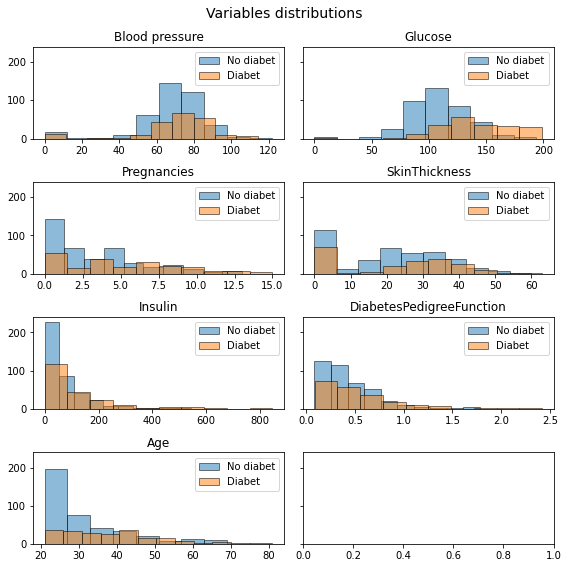

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
ps.options.plotting.backend = 'matplotlib'

eda_train = train.to_pandas_on_spark()

fig, axs = plt.subplots(4, 2, sharey=True, tight_layout=True, figsize = (8, 8))
fig.suptitle("Variables distributions", fontsize=14)
axs[0,0].hist(eda_train.loc[eda_train.Outcome == "0", ["BloodPressure"]].BloodPressure,  alpha = 0.5, ec="black", label="No diabet")
axs[0,0].hist(eda_train.loc[eda_train.Outcome == "1", ["BloodPressure"]].BloodPressure,  alpha = 0.5, ec="black", label = "Diabet")
axs[0,0].set_title("Blood pressure")
axs[0,0].legend()


axs[0,1].hist(eda_train.loc[eda_train.Outcome == "0", ["Glucose"]].Glucose,  alpha = 0.5, ec="black", label="No diabet")
axs[0,1].hist(eda_train.loc[eda_train.Outcome == "1", ["Glucose"]].Glucose,  alpha = 0.5, ec="black", label = "Diabet")
axs[0,1].set_title("Glucose")
axs[0,1].legend()

axs[1,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Pregnancies"]].Pregnancies,  alpha = 0.5, ec="black", label="No diabet")
axs[1,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Pregnancies"]].Pregnancies,  alpha = 0.5, ec="black", label = "Diabet")
axs[1,0].set_title("Pregnancies")
axs[1,0].legend()


axs[1,1].hist(eda_train.loc[eda_train.Outcome == "0", ["SkinThickness"]].SkinThickness,  alpha = 0.5, ec="black", label="No diabet")
axs[1,1].hist(eda_train.loc[eda_train.Outcome == "1", ["SkinThickness"]].SkinThickness,  alpha = 0.5, ec="black", label = "Diabet")
axs[1,1].set_title("SkinThickness")
axs[1,1].legend()


axs[2,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Insulin"]].Insulin,  alpha = 0.5, ec="black", label="No diabet")
axs[2,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Insulin"]].Insulin,  alpha = 0.5, ec="black", label = "Diabet")
axs[2,0].set_title("Insulin")
axs[2,0].legend()

axs[2,1].hist(eda_train.loc[eda_train.Outcome == "0", ["DiabetesPedigreeFunction"]].DiabetesPedigreeFunction,  alpha = 0.5, ec="black", label="No diabet")
axs[2,1].hist(eda_train.loc[eda_train.Outcome == "1", ["DiabetesPedigreeFunction"]].DiabetesPedigreeFunction,  alpha = 0.5, ec="black", label = "Diabet")
axs[2,1].set_title("DiabetesPedigreeFunction")
axs[2,1].legend()


axs[3,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Age"]].Age,  alpha = 0.5, ec="black", label="No diabet")
axs[3,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Age"]].Age,  alpha = 0.5, ec="black", label = "Diabet")
axs[3,0].set_title("Age")
axs[3,0].legend()

<AxesSubplot:title={'center':'Insulin vs # of pregnancies'}, xlabel='Insulin', ylabel='Pregnancies'>

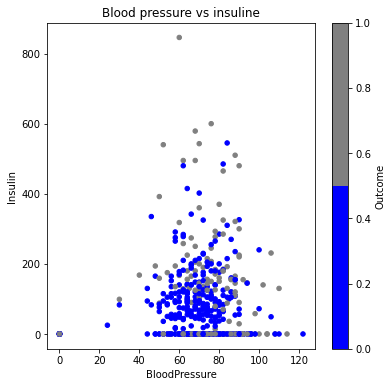

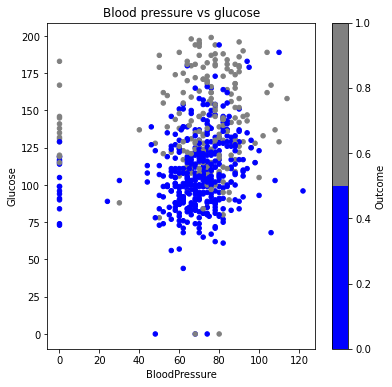

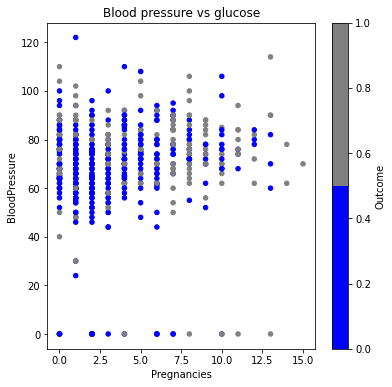

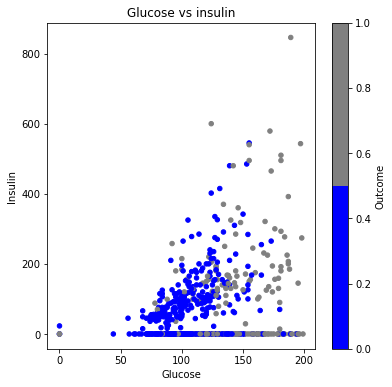

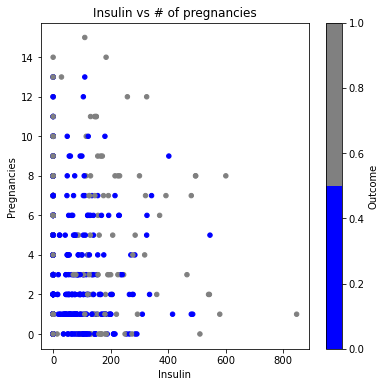

In [14]:


mycmap = colors.ListedColormap(['blue', 'grey'])
eda_train.plot.scatter(x='BloodPressure', y='Insulin', c = 'Outcome', colormap = mycmap, 
                       ylabel = "Insulin level", 
                       xlabel = "Blood pressure",
                       title = "Blood pressure vs insuline",
                       sharex = False,
                       figsize = (6, 6))

eda_train.plot.scatter(x='BloodPressure', y='Glucose', c = 'Outcome', colormap = mycmap, #colormap = "tab10",
                       ylabel = "Glucose", 
                       xlabel = "Blood pressure",
                       title = "Blood pressure vs glucose",
                       sharex = False,
                       figsize = (6, 6))

eda_train.plot.scatter(x='Pregnancies', y='BloodPressure', c = 'Outcome', colormap = mycmap, #colormap = "tab10",
                       ylabel = "BloodPressure", 
                       xlabel = "# of Pregnancies",
                       title = "Blood pressure vs glucose",
                       sharex = False,
                       figsize = (6, 6))

eda_train.plot.scatter(x='Glucose', y='Insulin', c = 'Outcome', colormap = mycmap, #colormap = "tab10",
                       ylabel = "Insulin", 
                       xlabel = "Glucose",
                       title = "Glucose vs insulin",
                       sharex = False,
                       figsize = (6, 6))
eda_train.plot.scatter(x='Insulin', y='Pregnancies', c = 'Outcome', colormap = mycmap, #colormap = "tab10",
                       ylabel = "# of pregnancies", 
                       xlabel = "Insulin",
                       title = "Insulin vs # of pregnancies",
                       sharex = False,
                       figsize = (6, 6))

In [15]:
eda_train[['BloodPressure', 'Pregnancies', 'Glucose', 'SkinThickness', 'Insulin','DiabetesPedigreeFunction', 'Age']].corr()

,BloodPressure,Pregnancies,Glucose,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
BloodPressure,1.000000,0.120236,0.149621,0.225103,0.088609,0.044674,0.240461
Pregnancies,0.120236,1.000000,0.125612,-0.096489,-0.061967,-0.066191,0.540907
Glucose,0.149621,0.125612,1.000000,0.045829,0.295180,0.107185,0.261922
SkinThickness,0.225103,-0.096489,0.045829,1.000000,0.449423,0.176543,-0.128871
Insulin,0.088609,-0.061967,0.295180,0.449423,1.000000,0.137497,-0.017874
DiabetesPedigreeFunction,0.044674,-0.066191,0.107185,0.176543,0.137497,1.000000,0.022669
Age,0.240461,0.540907,0.261922,-0.128871,-0.017874,0.022669,1.000000


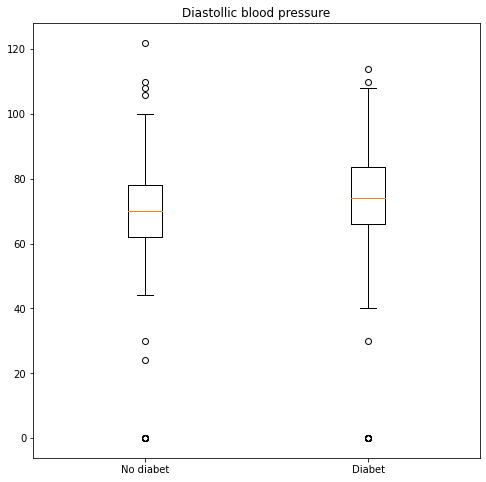

In [16]:
plt.rcParams['figure.figsize'] = [8, 8]
a = eda_train.loc[eda_train['Outcome'] == 0, 'BloodPressure']
b = eda_train.loc[eda_train['Outcome'] == 1, 'BloodPressure']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['No diabet','Diabet'])
plt.title ('Diastollic blood pressure')
plt.show()

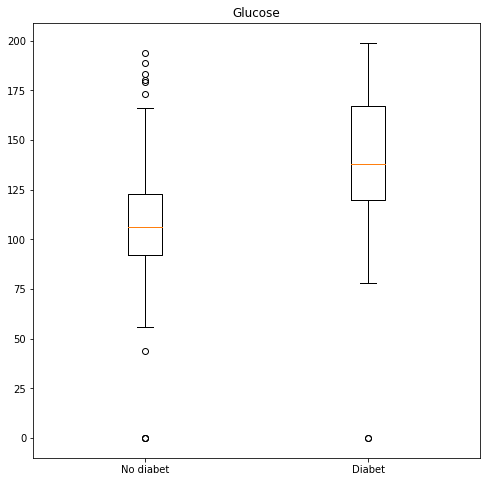

In [17]:
a = eda_train.loc[eda_train['Outcome'] == 0, 'Glucose']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Glucose']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['No diabet','Diabet'])
plt.title ('Glucose')
plt.show()

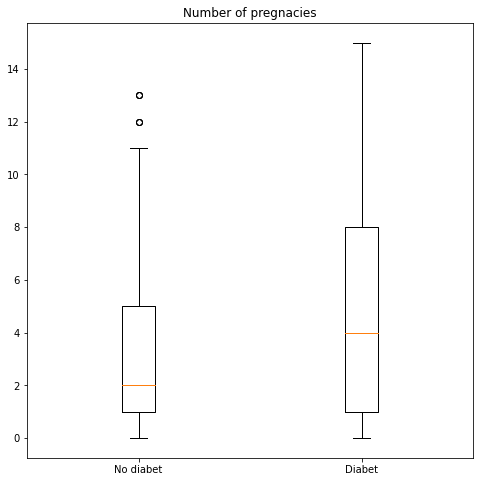

In [18]:
a = eda_train.loc[eda_train['Outcome'] == 0, 'Pregnancies']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Pregnancies']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['No diabet','Diabet'])
plt.title ('Number of pregnacies')
plt.show()

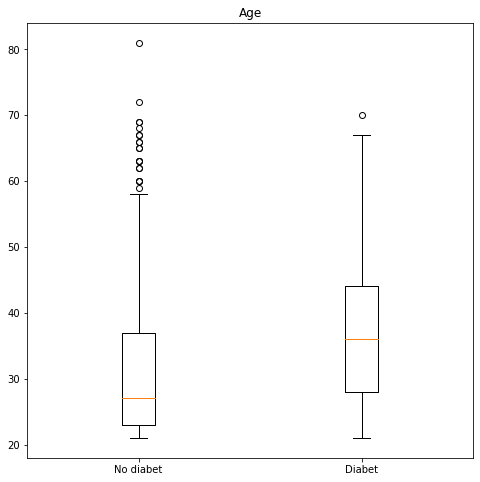

In [19]:
a = eda_train.loc[eda_train['Outcome'] == 0, 'Age']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Age']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['No diabet','Diabet'])
plt.title ('Age')
plt.show()

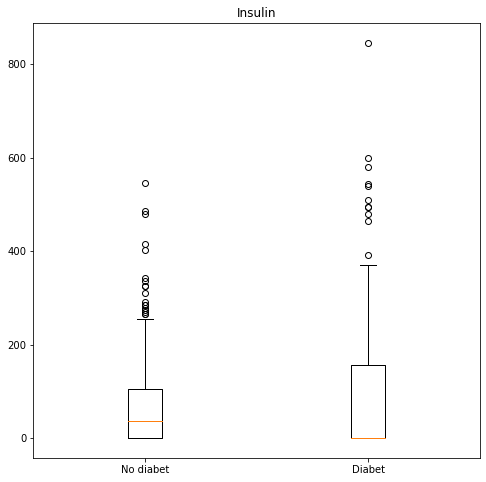

In [20]:
a = eda_train.loc[eda_train['Outcome'] == 0, 'Insulin']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Insulin']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['No diabet','Diabet'])
plt.title ('Insulin')
plt.show()

## Modeling 

Three different classes of models will be fitted.

### Model 1

In [21]:
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression()

sqlTrans = SQLTransformer(
    statement = "SELECT log(Age) as Age, Glucose, \
    Insulin, Pregnancies, BloodPressure, \
    outcome as label FROM __THIS__")

assembler = VectorAssembler(inputCols = ["Age", "Glucose", "Insulin", "Pregnancies", "BloodPressure"], outputCol = "features_for", handleInvalid = 'keep')

px = PolynomialExpansion(degree=2, inputCol="features_for", outputCol="features")

pipeline = Pipeline(stages = [sqlTrans, assembler, px, lr])

In [22]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .build()
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [23]:
cvModel = crossval.fit(train)

In [24]:
cvModel.avgMetrics

[0.8093296578022473, 0.815633690191808]

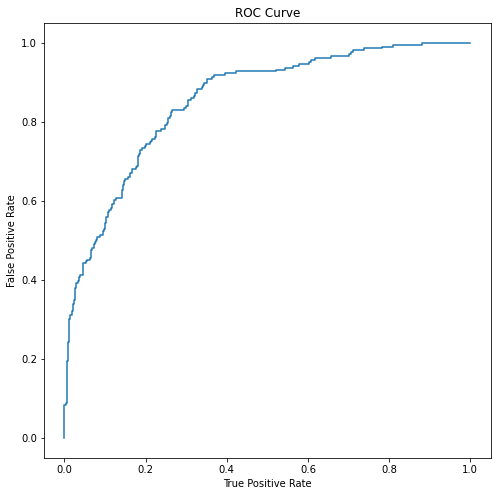

In [25]:
model_t= cvModel.bestModel.stages[3] 
trainingSummary = model_t.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

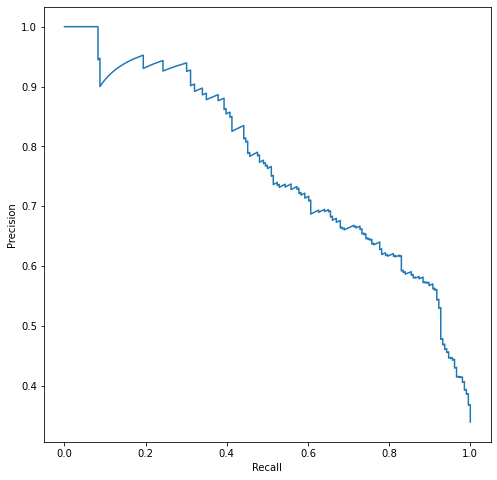

In [26]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [27]:
list(zip(cvModel.avgMetrics, paramGrid))

[(0.8093296578022473,
  {Param(parent='LogisticRegression_bd0c3cac4206', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_bd0c3cac4206', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LogisticRegression_bd0c3cac4206', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.815633690191808,
  {Param(parent='LogisticRegression_bd0c3cac4206', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_bd0c3cac4206', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LogisticRegression_bd0c3cac4206', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

In [28]:
cvModel.transform(test).show(5)

+------------------+-------+-------+-----------+-------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|               Age|Glucose|Insulin|Pregnancies|BloodPressure|label|        features_for|            features|       rawPrediction|         probability|prediction|
+------------------+-------+-------+-----------+-------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|3.4339872044851463|    118|    230|          0|           84|    1|[3.43398720448514...|[3.43398720448514...|[0.41917830734733...|[0.60328660932030...|       0.0|
|3.4339872044851463|     85|      0|          1|           66|    0|[3.43398720448514...|[3.43398720448514...|[2.13812000948563...|[0.89455340696130...|       0.0|
| 3.044522437723423|     89|     94|          1|           66|    0|[3.04452243772342...|[3.04452243772342...|[3.93093771339565...|[0.98075247661907...|       0.0|
|3.2188758248682

In [29]:
predictions = cvModel.transform(test)
metric = BinaryClassificationEvaluator().evaluate(predictions)
print(metric)

0.788041707396546


In [30]:
BinaryClassificationEvaluator().getMetricName()

'areaUnderROC'

In [31]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)#,labels=class_names)
cnf_matrix

array([[81, 18],
       [29, 33]])

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[81 18]
 [29 33]]


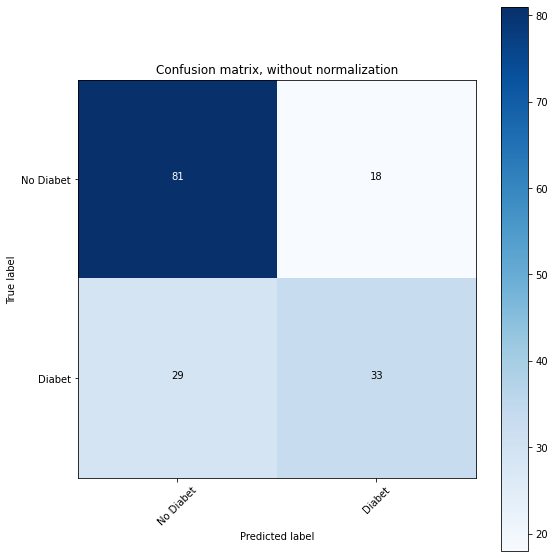

In [33]:
# Plot non-normalized confusion matrix
class_names =["No Diabet", "Diabet"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.81818182 0.18181818]
 [0.46774194 0.53225806]]


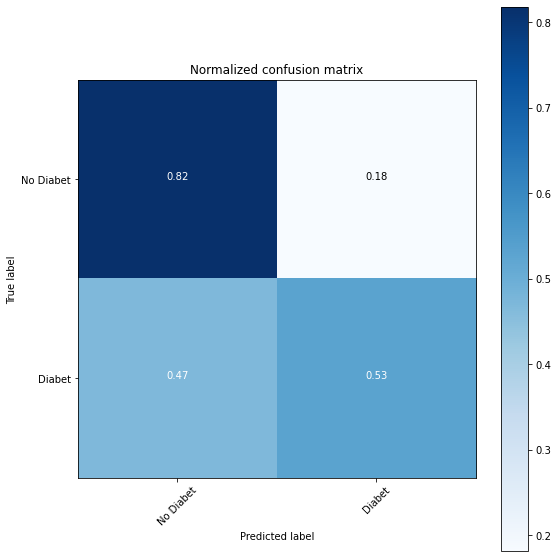

In [34]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

### Model 2

In [35]:
sqlTrans = SQLTransformer(
    statement = "SELECT Age, BloodPressure, \
    Pregnancies, Glucose, SkinThickness, \
    Insulin, DiabetesPedigreeFunction, \
    outcome as label FROM __THIS__"
)

assembler = VectorAssembler(inputCols = ["Age", "BloodPressure", "Pregnancies", "Glucose", "SkinThickness", "Insulin", "DiabetesPedigreeFunction"], outputCol = "features", handleInvalid = 'keep')
pipeline = Pipeline(stages = [sqlTrans, assembler, lr])

In [36]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .build()
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [37]:
cvModel = crossval.fit(train)

In [38]:
list(zip(cvModel.avgMetrics, paramGrid))

[(0.6747754930766758,
  {Param(parent='LogisticRegression_bd0c3cac4206', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_bd0c3cac4206', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LogisticRegression_bd0c3cac4206', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.8132052756027675,
  {Param(parent='LogisticRegression_bd0c3cac4206', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_bd0c3cac4206', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LogisticRegression_bd0c3cac4206', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

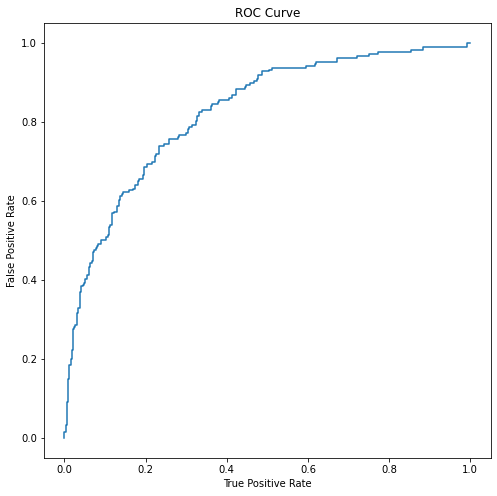

In [39]:
model2= cvModel.bestModel.stages[2]
trainingSummary = model2.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

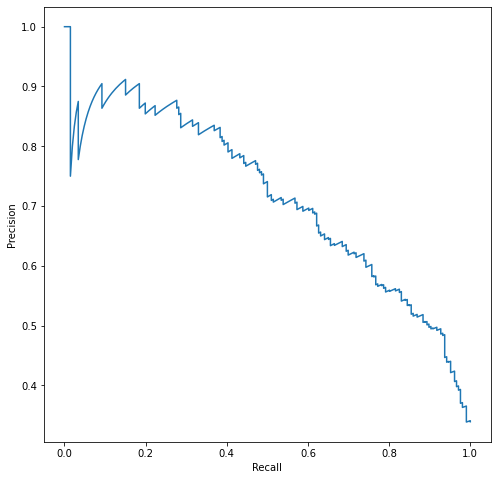

In [40]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [41]:
cvModel.transform(test).show(5)

+---+-------------+-----------+-------+-------------+-------+------------------------+-----+--------------------+--------------------+--------------------+----------+
|Age|BloodPressure|Pregnancies|Glucose|SkinThickness|Insulin|DiabetesPedigreeFunction|label|            features|       rawPrediction|         probability|prediction|
+---+-------------+-----------+-------+-------------+-------+------------------------+-----+--------------------+--------------------+--------------------+----------+
| 31|           84|          0|    118|           47|    230|                   0.551|    1|[31.0,84.0,0.0,11...|[1.27619027165464...|[0.78180057858445...|       0.0|
| 31|           66|          1|     85|           29|      0|     0.35100000000000003|    0|[31.0,66.0,1.0,85...|[2.55437184943487...|[0.92786667091247...|       0.0|
| 21|           66|          1|     89|           23|     94|     0.16699999999999998|    0|[21.0,66.0,1.0,89...|[2.74823545581670...|[0.93981361760609...|       0.0

In [42]:
predictions = cvModel.transform(test)

metric = BinaryClassificationEvaluator().evaluate(predictions)
print(metric)

0.7939068100358423


In [43]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)#,labels=class_names)
cnf_matrix

array([[83, 16],
       [27, 35]])

Confusion matrix, without normalization
[[83 16]
 [27 35]]


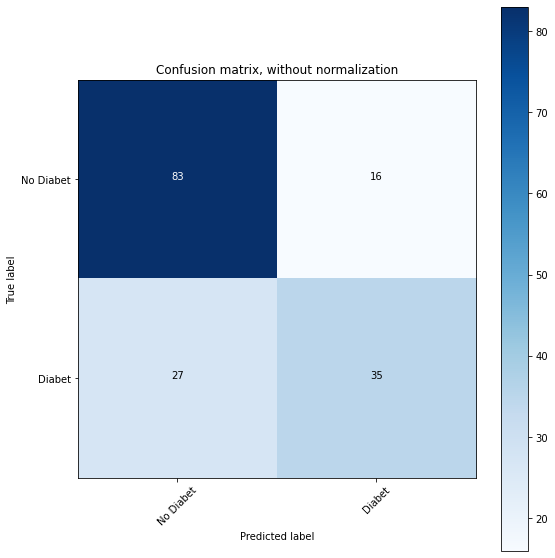

In [44]:
# Plot non-normalized confusion matrix
class_names =["No Diabet", "Diabet"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.83838384 0.16161616]
 [0.43548387 0.56451613]]


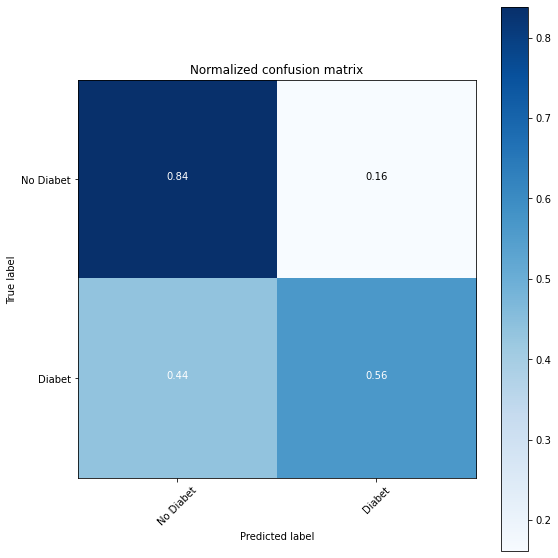

In [45]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 3

In [46]:
sqlTrans = SQLTransformer(
    statement = "SELECT Pregnancies, Glucose, Insulin, Glucose*Insulin as Inter, outcome as label FROM __THIS__")

assembler = VectorAssembler(inputCols = ["Pregnancies", "Glucose", "Insulin", "Inter"], outputCol = "features", handleInvalid = 'keep')

#px = PolynomialExpansion(degree=2, inputCol="features_for", outputCol="features")

#pipeline = Pipeline(stages = [sqlTrans, assembler, px, lr])

pipeline = Pipeline(stages = [sqlTrans, assembler, lr])

In [47]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .build()
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [48]:
cvModel = crossval.fit(train)

In [49]:
list(zip(cvModel.avgMetrics, paramGrid))

[(0.6530997020381172,
  {Param(parent='LogisticRegression_bd0c3cac4206', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_bd0c3cac4206', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LogisticRegression_bd0c3cac4206', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.8097408454271542,
  {Param(parent='LogisticRegression_bd0c3cac4206', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_bd0c3cac4206', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LogisticRegression_bd0c3cac4206', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

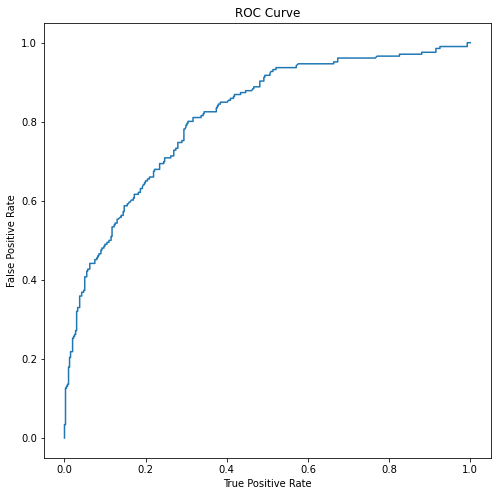

In [50]:
model3= cvModel.bestModel.stages[2]
trainingSummary = model3.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

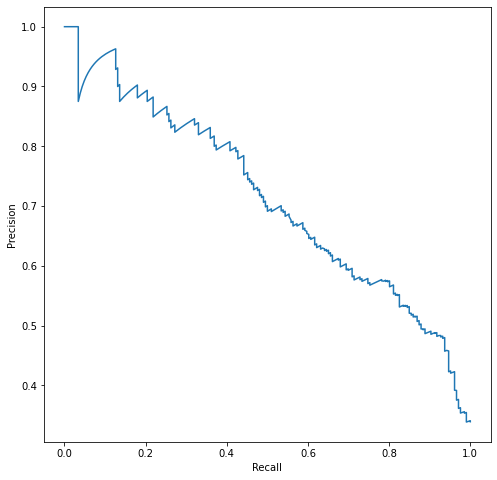

In [51]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [52]:
cvModel.transform(test).show(5)

+-----------+-------+-------+-----+-----+--------------------+--------------------+--------------------+----------+
|Pregnancies|Glucose|Insulin|Inter|label|            features|       rawPrediction|         probability|prediction|
+-----------+-------+-------+-----+-----+--------------------+--------------------+--------------------+----------+
|          0|    118|    230|27140|    1|[0.0,118.0,230.0,...|[1.58755768427882...|[0.83027220884585...|       0.0|
|          1|     85|      0|    0|    0|  [1.0,85.0,0.0,0.0]|[2.43537311792707...|[0.91948521393093...|       0.0|
|          1|     89|     94| 8366|    0|[1.0,89.0,94.0,83...|[2.51717784726737...|[0.92533731135465...|       0.0|
|          1|     95|     38| 3610|    0|[1.0,95.0,38.0,36...|[2.15245911331873...|[0.89589834823540...|       0.0|
|          1|    101|     36| 3636|    0|[1.0,101.0,36.0,3...|[1.91944740956577...|[0.87207679999867...|       0.0|
+-----------+-------+-------+-----+-----+--------------------+----------

In [53]:
predictions = cvModel.transform(test)
metric = BinaryClassificationEvaluator().evaluate(predictions)
print(metric)

0.755131964809384


Confusion matrix, without normalization
[[83 16]
 [27 35]]


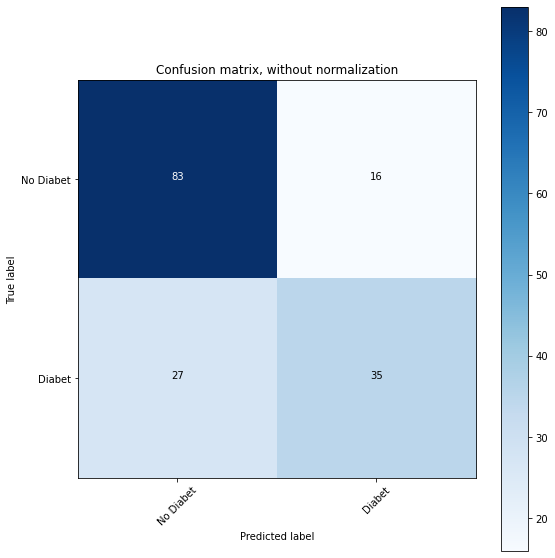

In [54]:
class_names =["No Diabet", "Diabet"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.83838384 0.16161616]
 [0.43548387 0.56451613]]


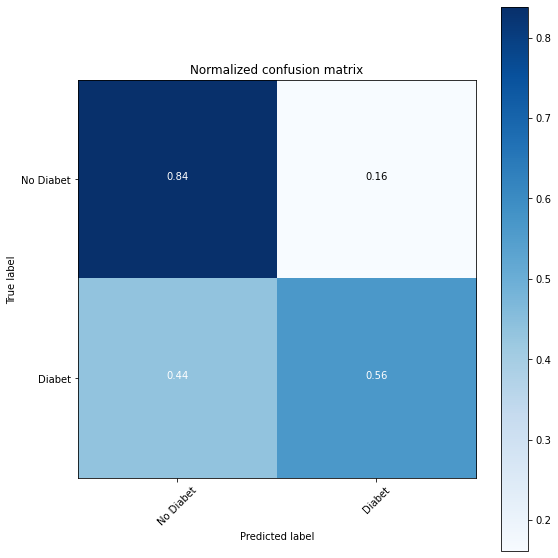

In [55]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()